# Plotting and Experiment Data Analysis

## Preamble

General imports, setting up constants, plot configuration, etc.

In [364]:
import os
import re
import sys
print("Using Python executable: {}".format(sys.executable))

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2.25)

sys.path.append('..')
from get_data import FILE_NAMES


Using Python executable: /home/andreib/miniconda/envs/csc2305/bin/python


In [208]:
%pwd

'/home/andreib/work/numerics-from-scratch/csc2305/project/analysis'

In [209]:
# Each point in the reconstruction is just a 3D point, so it has three parameters.
PARAMS_PER_POINT = 3
# Each camera has a 6 DoF 3D rigid pose, plus three intrinsic parameters: focal length (same x and y),
# and two radial distorsion params.
PARAMS_PER_CAMERA = 6 + 3

SEQUENCE_NAMES = ['trafalgar', 'venice', 'dubrovnik']
# dubrovnik, ladybug are the others. 'final' is a set of gigantic problems which should
# probably be solved using a compute cluster.

PLOT_OUT = os.path.join('..', 'plots')
os.makedirs(PLOT_OUT, exist_ok=True)

EXP_ROOT = os.path.join('..', 'experiments')
assert len(os.listdir(EXP_ROOT)), "The experiment directory should not be empty."

## Data Loading

In [140]:
files = os.listdir(EXP_ROOT)
seq = 'trafalgar'

print(FILE_NAMES[seq])

['problem-21-11315-pre.txt', 'problem-39-18060-pre.txt', 'problem-50-20431-pre.txt', 'problem-126-40037-pre.txt', 'problem-138-44033-pre.txt', 'problem-161-48126-pre.txt', 'problem-170-49267-pre.txt', 'problem-174-50489-pre.txt', 'problem-193-53101-pre.txt', 'problem-201-54427-pre.txt', 'problem-206-54562-pre.txt', 'problem-215-55910-pre.txt', 'problem-225-57665-pre.txt', 'problem-257-65132-pre.txt']


In [141]:
from collections import namedtuple

ExperimentParams = namedtuple(
    'ExperimentParams', 
    ['min_type', 'tr_strategy', 'dogleg_type', 'linear_solver_type', 'line_search_type', 'nlcg_type'])

def parse_meta(meta_fpath):
    with open(meta_fpath, 'r') as meta_file:
        raw_line = meta_file.readlines()[0]
        #     TRUST_REGION,LEVENBERG_MARQUARDT,TRADITIONAL_DOGLEG,DENSE_SCHUR,LBFGS,FLETCHER_REEVES
        return ExperimentParams(*(raw_line.strip().split(',')))

def parse_raw(raw_fpath):
    n_residuals = -3
    with open(raw_fpath, 'r') as raw_file:
        for line in raw_file.readlines():
            if 'residuals' in line.lower():
                n_residuals = int(line.split()[1])

    if -3 == n_residuals:
        raise ValueError("Could not parse raw file!")
    return n_residuals

In [346]:
def ap_list(m, key, element):
    """Helper method for managing a map where each value is a list."""
    if key not in m:
        m[key] = []
    m[key].append(element)

def load_files(root, sequence_name = 'trafalgar', subdir=None, skip_short=True):
    """Main data loader function. 
    
    Root should be the same as the output dir indicated when running the Ceres experiments.
    """
    
    # List all subdirectories of the experiment root. I organize my experiments into
    # subfolders like '00', '01', etc., to have a general (but not at all rigorous!)
    # sense of when those experiments were made.
    if subdir is None:
        files = [os.path.join(root, sdir, file)
                 for sdir in os.listdir(root) 
                 for file in os.listdir(os.path.join(root, sdir))]
    else:
        files = [os.path.join(root, subdir, file) for file in os.listdir(os.path.join(root, subdir))]

        
    agg = {
        category: { } for category in ['lm', 'dogleg', 'LBFGS', 'CG-ls', 'SD']
    }
    
    for file in files:
        if file.endswith(".csv") and sequence_name in file:
            _, seq_name, _, n_images_s, n_points_s, *rest = file.split('-')
            n_images = int(n_images_s)
            n_points = int(n_points_s)
            
            params = parse_meta(file.replace('.csv', '.meta.txt'))
            n_residuals = parse_raw(file.replace('.csv', '.raw_summary.txt'))
            if n_residuals == -1:
#                 print("WARNING: optimization method [{}] failed. Not loading.".format(file))
                # The used dogleg implementation does not support inexact solvers, only factorization-based ones.
                # Therefore, getting these failures is OK.
                assert params.min_type == 'TRUST_REGION' and params.tr_strategy == 'DOGLEG' and \
                    params.linear_solver_type in ['ITERATIVE_SCHUR', 'CGNR']
                continue

            df = pd.read_csv(file)
            iterations = len(df)
            final_cost = df['cost'].iloc[-1]
            final_seconds = df['cumulative_time_in_seconds'].iloc[-1]
            
            if iterations <= 2 and skip_short:
                print("WARNING: skipping [{}] because of only {} interation(s).".format(file, iterations))
                continue
            
            # Use some ugly heuristics to label methods to make plotting a bit easier
            method_name = None
            if params.min_type == 'TRUST_REGION':
                if params.tr_strategy == 'LEVENBERG_MARQUARDT':
                    c = 'lm'
                    method_name = "lm-" + str(params.linear_solver_type)
                    
                    # In later experiments, I remembered to also include the max number of
                    # linear solver iterations in the file name, so only look for it and
                    # attempt to parse it if it's already there.
                    if len(rest) > 5:
                        iterative_schur = 'ITERATIVE_SCHUR'
                        if params.linear_solver_type == iterative_schur:
                            max_solver_its = int(rest[rest.index(iterative_schur) + 1])
#                             print(max_solver_its)
                            method_name += str(max_solver_its)
                else:
                    c = 'dogleg'
                    method_name = "dogleg-" + str(params.dogleg_type) + "-" + str(params.linear_solver_type)
            else:
                if params.line_search_type == 'LBFGS':
                    c = 'LBFGS'
                    method_name = c
                elif params.line_search_type == 'NONLINEAR_CONJUGATE_GRADIENT':
                    c = 'CG-ls'
                    method_name = c + ' ' + str(params.nlcg_type)
                elif params.line_search_type == 'STEEPEST_DESCENT':
                    c = 'SD'
                    method_name = c
                else:
                    raise ValueError("Unknown line search type: {}".format(params.line_search_type))
                
                
            ap_list(agg[c], 'method', method_name)
            ap_list(agg[c], 'n_images', n_images)
            ap_list(agg[c], 'n_points', n_points)
            ap_list(agg[c], 'n_params', n_points * PARAMS_PER_POINT + n_images * PARAMS_PER_CAMERA)
            ap_list(agg[c], 'iterations', iterations)        
            ap_list(agg[c], 'final_cost', final_cost)
            ap_list(agg[c], 'normalized_final_cost', final_cost * 1.0 / n_residuals)
            ap_list(agg[c], 'time_seconds', final_seconds)
        
    return {key: pd.DataFrame(vals) for (key, vals) in agg.items()}

data = {sequence_name: load_files(EXP_ROOT, sequence_name) for sequence_name in SEQUENCE_NAMES}

In [347]:
print(data.keys())
for seq in data:
    for key in data[seq]:
        print("{} experiments in category {} of sequence {}.".format(len(data[seq][key]), key, seq))

dict_keys(['trafalgar', 'venice', 'dubrovnik'])
182 experiments in category lm of sequence trafalgar.
84 experiments in category dogleg of sequence trafalgar.
2 experiments in category LBFGS of sequence trafalgar.
6 experiments in category CG-ls of sequence trafalgar.
2 experiments in category SD of sequence trafalgar.
0 experiments in category lm of sequence venice.
46 experiments in category dogleg of sequence venice.
0 experiments in category LBFGS of sequence venice.
0 experiments in category CG-ls of sequence venice.
0 experiments in category SD of sequence venice.
32 experiments in category lm of sequence dubrovnik.
33 experiments in category dogleg of sequence dubrovnik.
0 experiments in category LBFGS of sequence dubrovnik.
0 experiments in category CG-ls of sequence dubrovnik.
0 experiments in category SD of sequence dubrovnik.


## Analyze the Levenberg-Marquardt and Dogleg families

In [348]:
x_pretty = {
    'n_points': 'Number of 3D points',
    'n_images': 'Number of input images',
    'n_params': 'Total number of parameters',
}

y_pretty = {
    'iterations': "Iterations to convergence",
    'time_seconds': "Total run time (seconds)",
    'final_cost': "Total final solution residual (px)",
    'normalized_final_cost': "Mean final solution residual (px)",
}

Text(0.5,0.98,'We will use this to show failed line search runs')

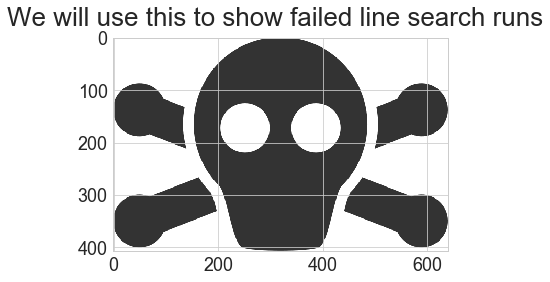

In [349]:
skull_icon = read_png('./skull.png')
plt.imshow(skull_icon)
plt.suptitle("We will use this to show failed line search runs")

In [350]:
def screaming_snake_to_human(token):
    """Converts SCREAMING_SNAKE_CASE to Human Friendly Names."""
    parts = token.split("_")
    return " ".join(part.capitalize() for part in parts)

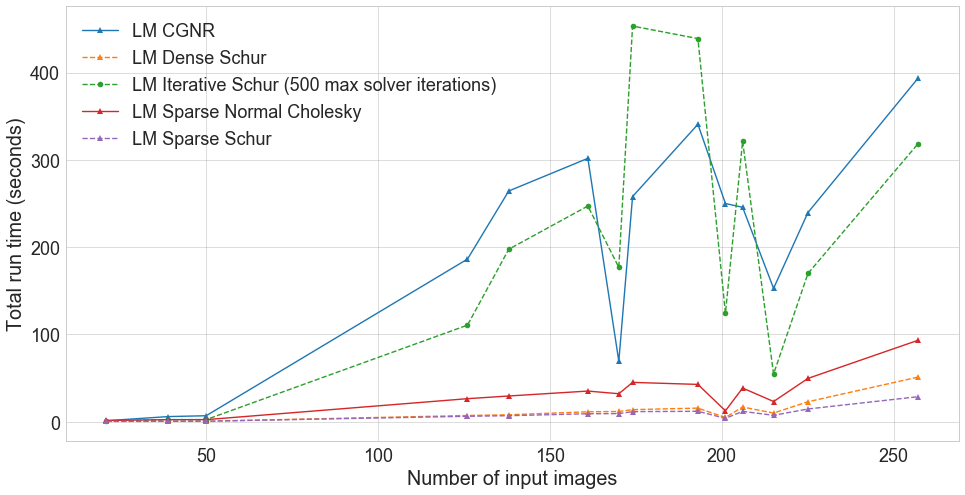

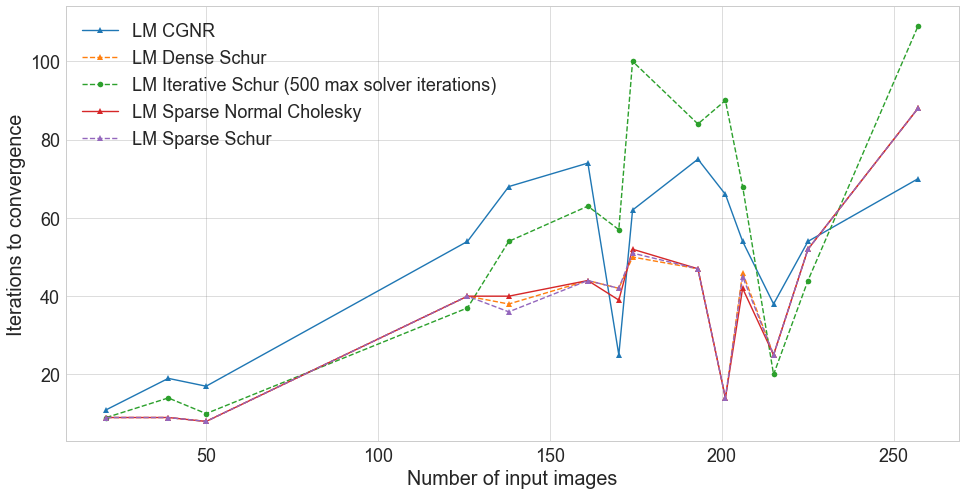

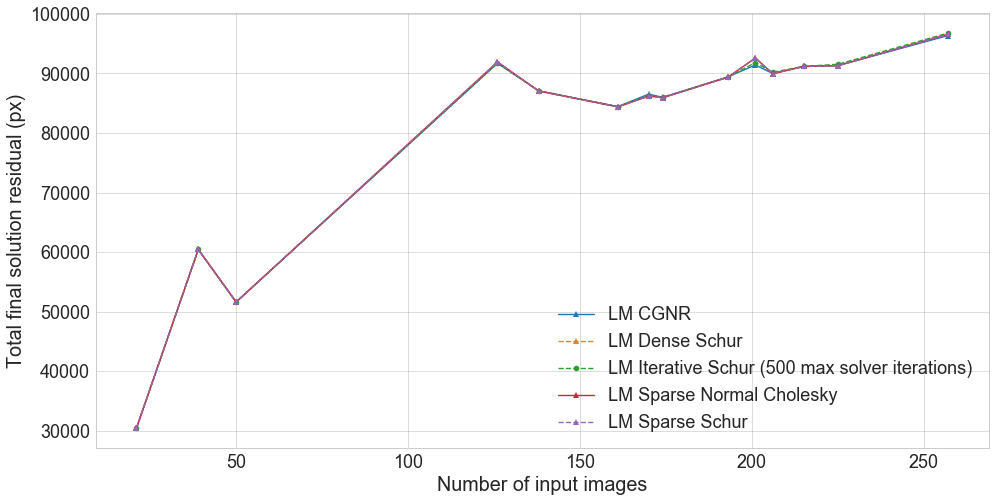

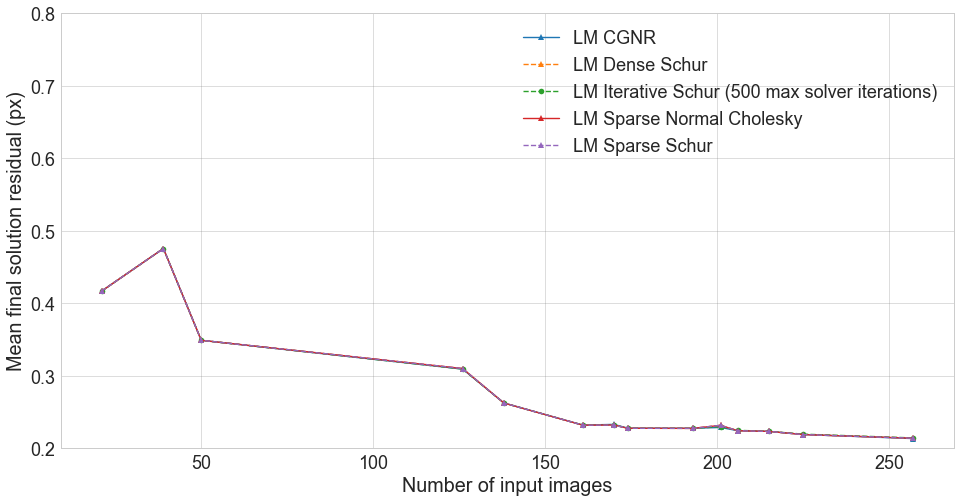

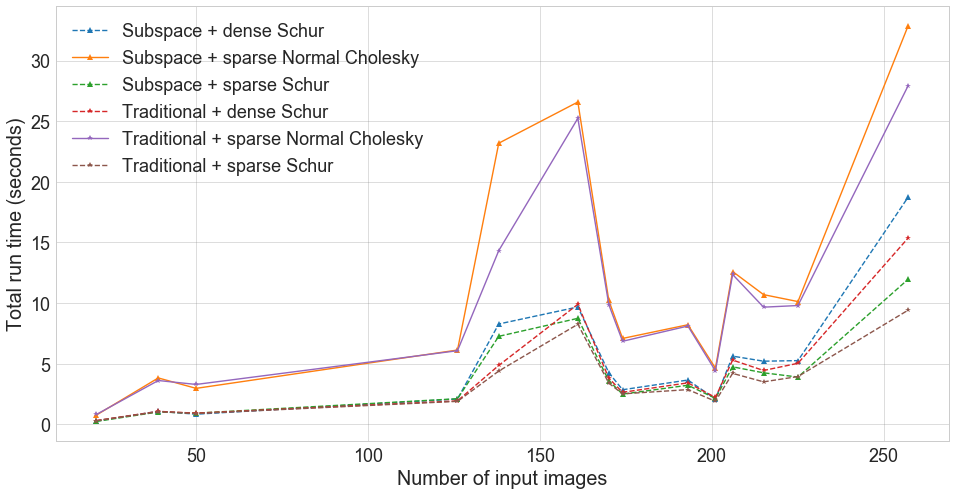

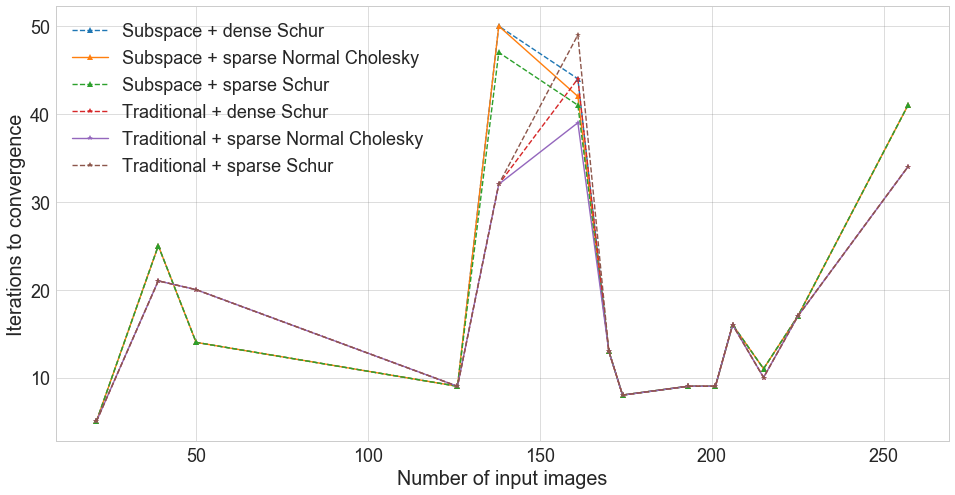

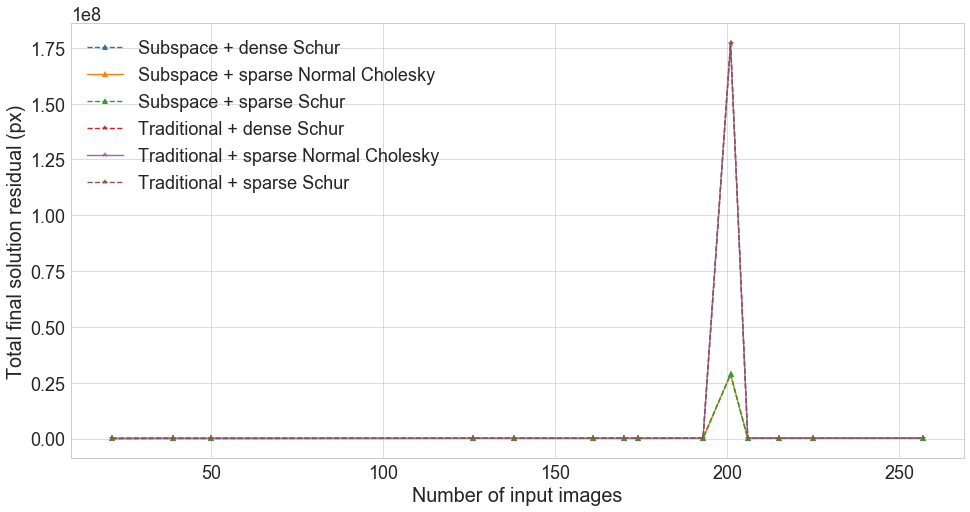

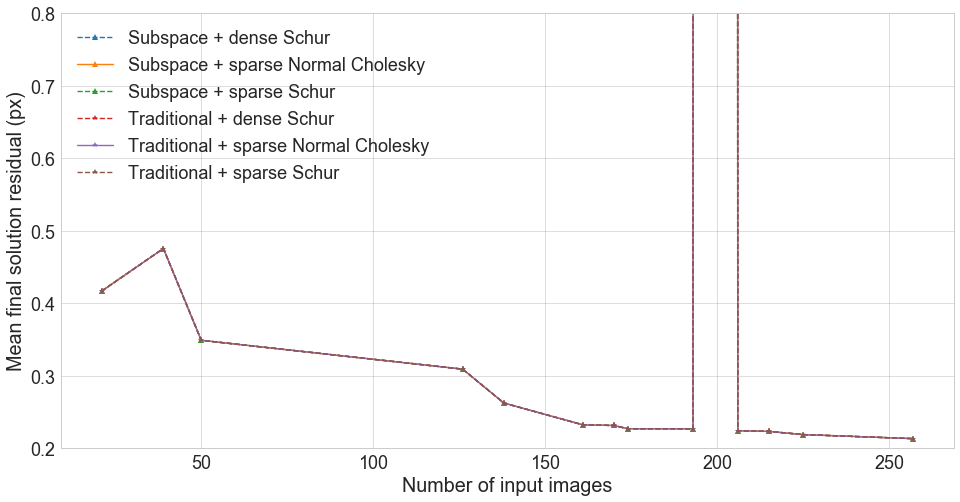

In [365]:
def setup_plot():
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(1, 1, 1)
    return ax

def finalize_plot(ax, x_axis, y_axis, **kw):
    ax.set_xlabel(x_pretty[x_axis])
    ax.set_ylabel(y_pretty[y_axis])
    ax.grid(color='gray', alpha=0.33)
    
    top_hline = kw.get('top')
    if top_hline is not None:
        ax.axhline([top_hline], linestyle='--')
    
    if 'normalized' in y_axis:
        ax.set_ylim([0.20, 0.80])
#     elif 'final_cost' == y_axis:
#         # A bit hacky, and may not work for dubrovnik/venice...
#         ax.set_ylim([0.00, 125000])

    # Calling this in the end ensures proper positioning.
    ax.legend()

def plot_category(data, seq, category, x_axis='n_images', y_axis='time_seconds', **kw):
    """Main workhorse plotting function.
    
    Meant to plot the behavior (total time taken, final cost, iterations) of the algorithms
    from a group (say, all LM configs with different linear solvers), as a function of
    the problem size. So each datapoint is meant to be a single experiment run to convergence
    or failure.
    
    The problem size can be measured as the number of images, the number of parameters, etc.
    """
    
    frame = data[seq][category]
    methods = kw.get('methods', sorted(frame['method'].unique()))
    schur_its = kw.get('schur_its', [500])
#     print(methods)
    save = kw.get('save', False)
    save_prefix = kw.get('save_prefix', "")
    skulls = kw.get('skulls', True)
    skull_iteration_threshold = kw.get('skull_iteration_threshold', 3)

    # Allow multiple calls to plot onto the same canvas
    ax = kw.get('ax')
    if ax is None: 
        ax = setup_plot()
    for m in methods:
        # Set up this method's plot markers
        if 'dense' in m.lower() or 'cgnr' in m.lower():
            marker = '*'
        if 'iterative' in m.lower():
            marker = 'o'
        else:
            marker = '^'
            
        # Set up this method's line style
        if 'schur' in m.lower():
            style = '--'
        else:
            style = '-'
        
        # TODO-LOW(andreib): The label computations are pretty hacky.
        # Make the experiment label human-readable
        label = m[m.find('-') + 1:]
        if label not in ["CGNR", "BFGS", "LBFGS"]:
            label = screaming_snake_to_human(label)
        if category == 'lm':
            label = "LM " + label
        if category == 'dogleg':
            label = label.replace('Dogleg-', '+ ')
        if category == 'SD':
            label = 'Steepest Descent'
        if category == 'CG-ls':
            label = "CG " + screaming_snake_to_human(m[m.find(' ') + 1:])
            
        # Hacky way to add a space before the iteration count in the label
        if 'iterative schur' in label.lower():
            its = re.search(r'[0-9]+', label)
            if its is not None:
                its = its.group(0)
                its_idx = label.find(its)
                label = label[:its_idx] + " (" + label[its_idx:] + " max solver iterations)"
            
        if category == 'dogleg':
            if 'traditional' in m.lower():
                marker = '*'
            elif 'subspace' in m.lower():
                marker = '^'
            else:
                raise ValueError("Unknown dogleg method category [{}]!".format(category))
                
        # When including iterative schur, allow filtering based on the number of
        # maximum iterations, so as not to overcrowd the plots.
        if 'iterative_schur' in m.lower():
            its_str = m[m.lower().find('iterative_schur')+len('iterative_schur'):]
            if len(its_str):                
                its = int(its_str)
            else:
                # In older experiments the iteration count is not mentioned, and in those
                # we use the default 500. We just skip those old results.
                continue
                
            if its not in schur_its:
                continue

        # Plot the experiment's line
        sorted_res = frame[frame['method'] == m].sort_values(by='n_images')
        sorted_res.plot(x_axis, y_axis, linestyle=style, marker=marker, ax=ax, label=label)
        
        if skulls:
            # Render a little skull on the plot where an algorithm failed (i.e., made very
            # few iterations, which is indicative of a failure).
            bad_runs = sorted_res[sorted_res['iterations'] <= skull_iteration_threshold]
            for index, row in bad_runs.iterrows():
                imagebox = OffsetImage(skull_icon, zoom=0.045)
                xy = [row[x_axis], row[y_axis]]
                ab = AnnotationBbox(imagebox,
                    xy,
                    xybox=(0, 0),
                    xycoords='data',
                    boxcoords='offset points',
                    frameon=False,
                )
                ax.add_artist(ab)
                
                
            
    if 'ax' in kw:
        del kw['ax']
    finalize_plot(ax, x_axis, y_axis, **kw)
    
    # small hack
    if 'dogleg' == category:
        plt.legend(loc='upper left')
    
    if save:
        fig_fpath = os.path.join(PLOT_OUT, "separate-{}{}-{}-{}-{}".format("" if save_prefix == "" else save_prefix + "-",
                                                                           seq, category, x_axis, y_axis))
        plt.savefig(fig_fpath + ".png")
        plt.savefig(fig_fpath + ".eps")
    return ax
    
save = False
top_seconds = None
plot_category(data, 'trafalgar', 'lm', 'n_images', 'time_seconds', top=top_seconds, save=save)
# print("Important note: the iteration count for iterative Shur is capped at 500, which is very high.")
plot_category(data, 'trafalgar', 'lm', 'n_images', 'iterations', top=top_seconds, save=save)
plot_category(data, 'trafalgar', 'lm', 'n_images', 'final_cost', top=None, save=save)
plot_category(data, 'trafalgar', 'lm', 'n_images', 'normalized_final_cost', top=None, save=save)

plot_category(data, 'trafalgar', 'dogleg', 'n_images', 'time_seconds', top=top_seconds, save=save)
plot_category(data, 'trafalgar', 'dogleg', 'n_images', 'iterations', top=top_seconds, save=save)
plot_category(data, 'trafalgar', 'dogleg', 'n_images', 'final_cost', top=None, save=save)
plot_category(data, 'trafalgar', 'dogleg', 'n_images', 'normalized_final_cost', top=None, save=save)


## Venice Experiments (Dogleg)

These sequences are typically much larger than the Trafalgar ones, meaning that LM approaches can take ~1h to solve some of them, which is a bit too long for practical purposes. The dogleg methods, on the other hand, seem to be much faster!

These experiments seem to fluctuate a lot. 
I would need several runs of each to get confident run time results, and given that the Venice problems
are some of the hardest, I ended up dropping this from the report. :(

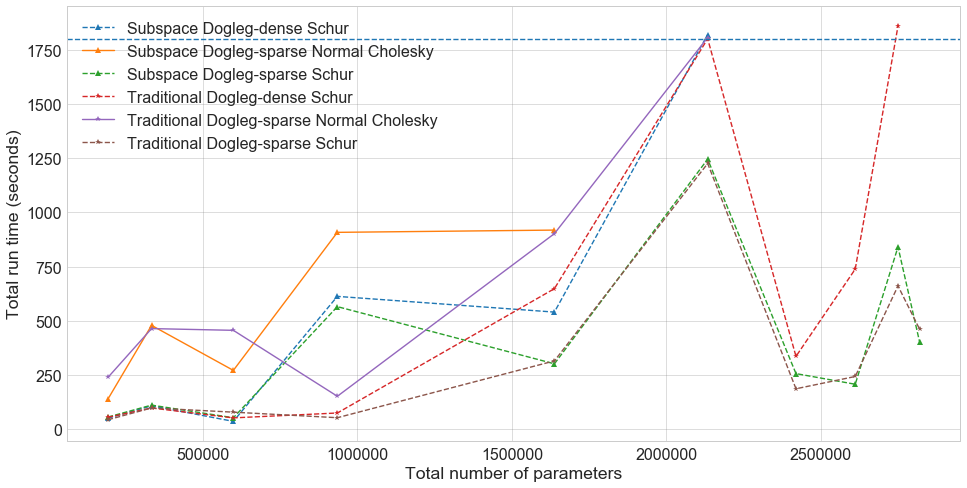

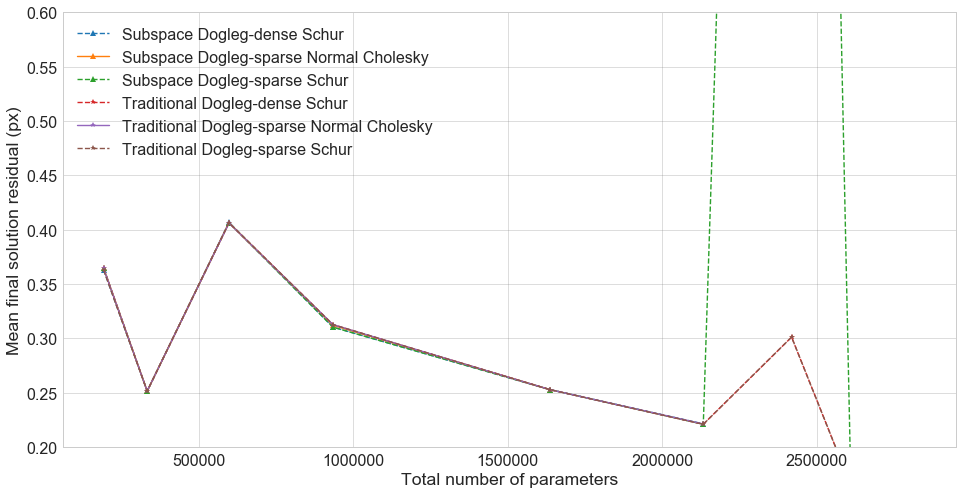

In [47]:
# TODO(andreib): Re-run venice experiments with higher time limit since you had a bug in the previous runs!
plot_category(data, 'venice', 'dogleg', 'n_params', 'time_seconds', top=1800)
plot_category(data, 'venice', 'dogleg', 'n_params', 'normalized_final_cost', top=None)

## Iterative Schur Experiments

Plotting various stats of the LM method using the iterative Schur solver, as a function of problem size and max numer of iterations.

In [224]:
data_it_schur = {'trafalgar': load_files('../experiments', subdir='01', sequence_name = 'trafalgar')}

Levenberg-Marquardt using an iterative schur complement solver and a smart number of maximum iterations can be almost on par with a dogleg method, while sacrificing relatively little in terms of final accuracy.


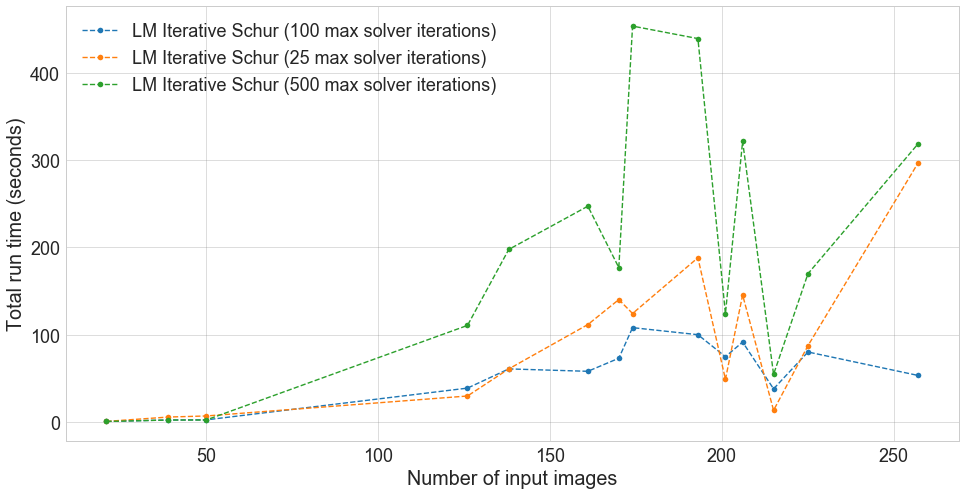

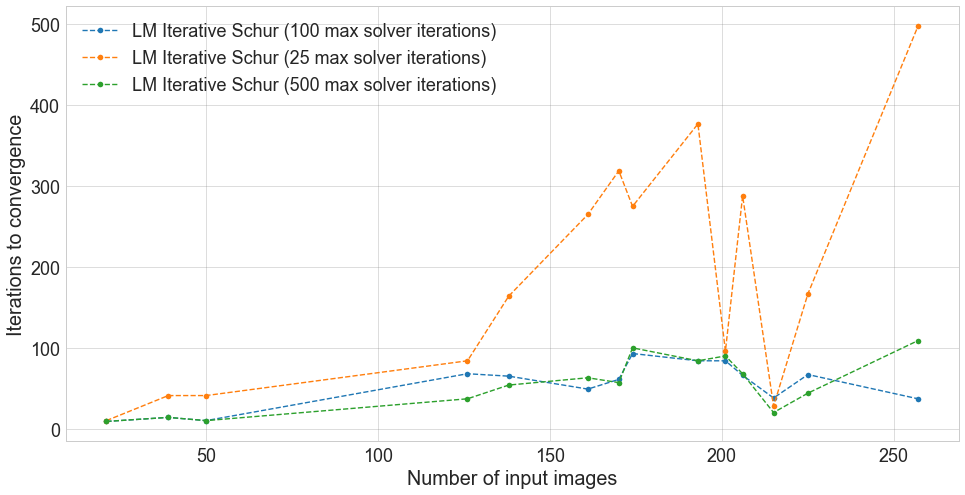

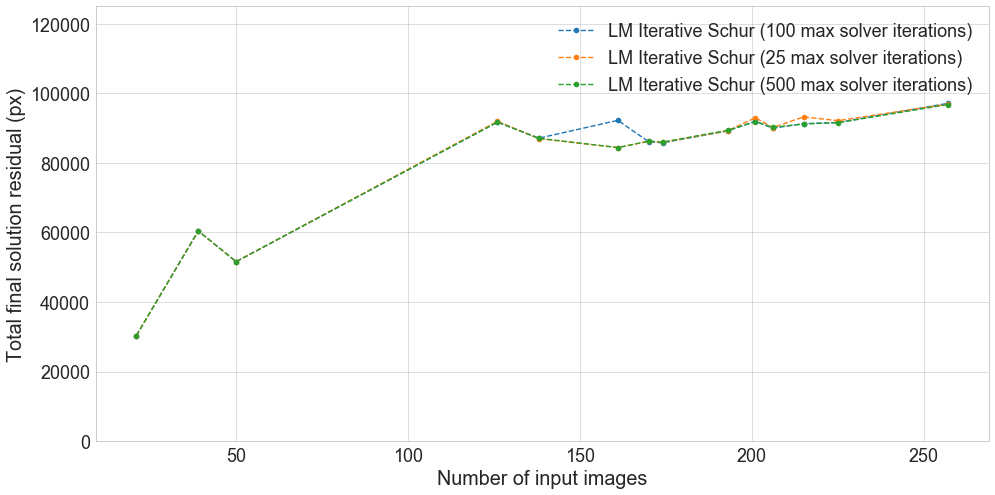

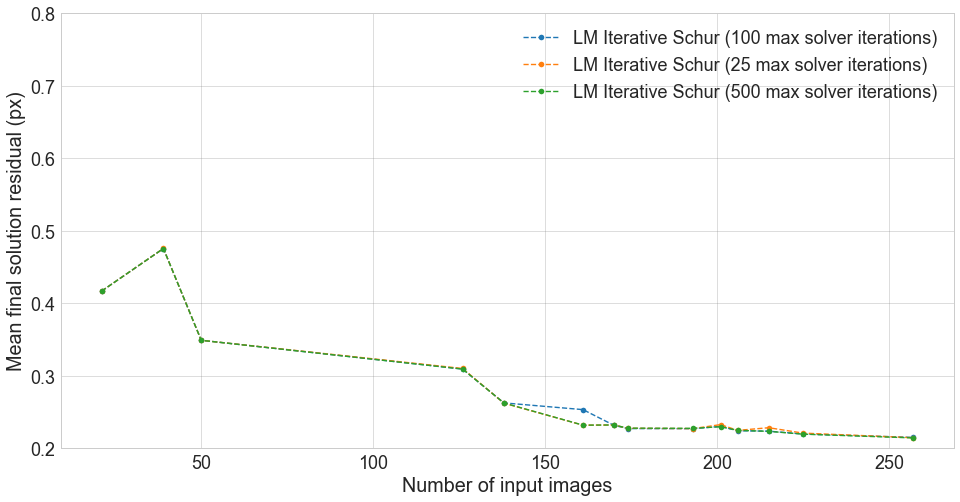

In [227]:
schur_its = {25, 100, 500}
print("Levenberg-Marquardt using an iterative schur complement solver and a smart number of maximum iterations " \
      "can be almost on par with a dogleg method, while sacrificing relatively little in terms of final accuracy.")
plot_category(data_it_schur, 'trafalgar', 'lm', 'n_images', 'time_seconds', top=None, schur_its=schur_its, save=True, save_prefix='it_sch')
plot_category(data_it_schur, 'trafalgar', 'lm', 'n_images', 'iterations', top=None, schur_its=schur_its, save=True, save_prefix='it_sch')
plot_category(data_it_schur, 'trafalgar', 'lm', 'n_images', 'final_cost', top=None, schur_its=schur_its, save=True, save_prefix='it_sch')
plot_category(data_it_schur, 'trafalgar', 'lm', 'n_images', 'normalized_final_cost', top=None, schur_its=schur_its, save=True, save_prefix='it_sch')

## Joint Tables and Plots

We now pick the best-performing solver from each class and plot them together on the Trafalgar sequences.

In [162]:
print(data.keys())
print(data_it_schur.keys())

dict_keys(['trafalgar', 'venice', 'dubrovnik'])
dict_keys(['trafalgar'])


In [163]:
joint_plot_seq = 'dubrovnik'
print("Experiment labels")
print("=> LM")
print(data[joint_plot_seq]['lm']['method'].unique())
print("=> DogLeg")
print(data[joint_plot_seq]['dogleg']['method'].unique())


Experiment labels
=> LM
['lm-SPARSE_SCHUR' 'lm-ITERATIVE_SCHUR100']
=> DogLeg
['dogleg-SUBSPACE_DOGLEG-SPARSE_SCHUR'
 'dogleg-TRADITIONAL_DOGLEG-SPARSE_SCHUR'
 'dogleg-TRADITIONAL_DOGLEG-SPARSE_NORMAL_CHOLESKY']


Candidates should be:
 * LM + iterative schur 100
 * LM + sparse schur
 * Tra DogLeg + sparse schur
 * SS DogLeg + sparse schur

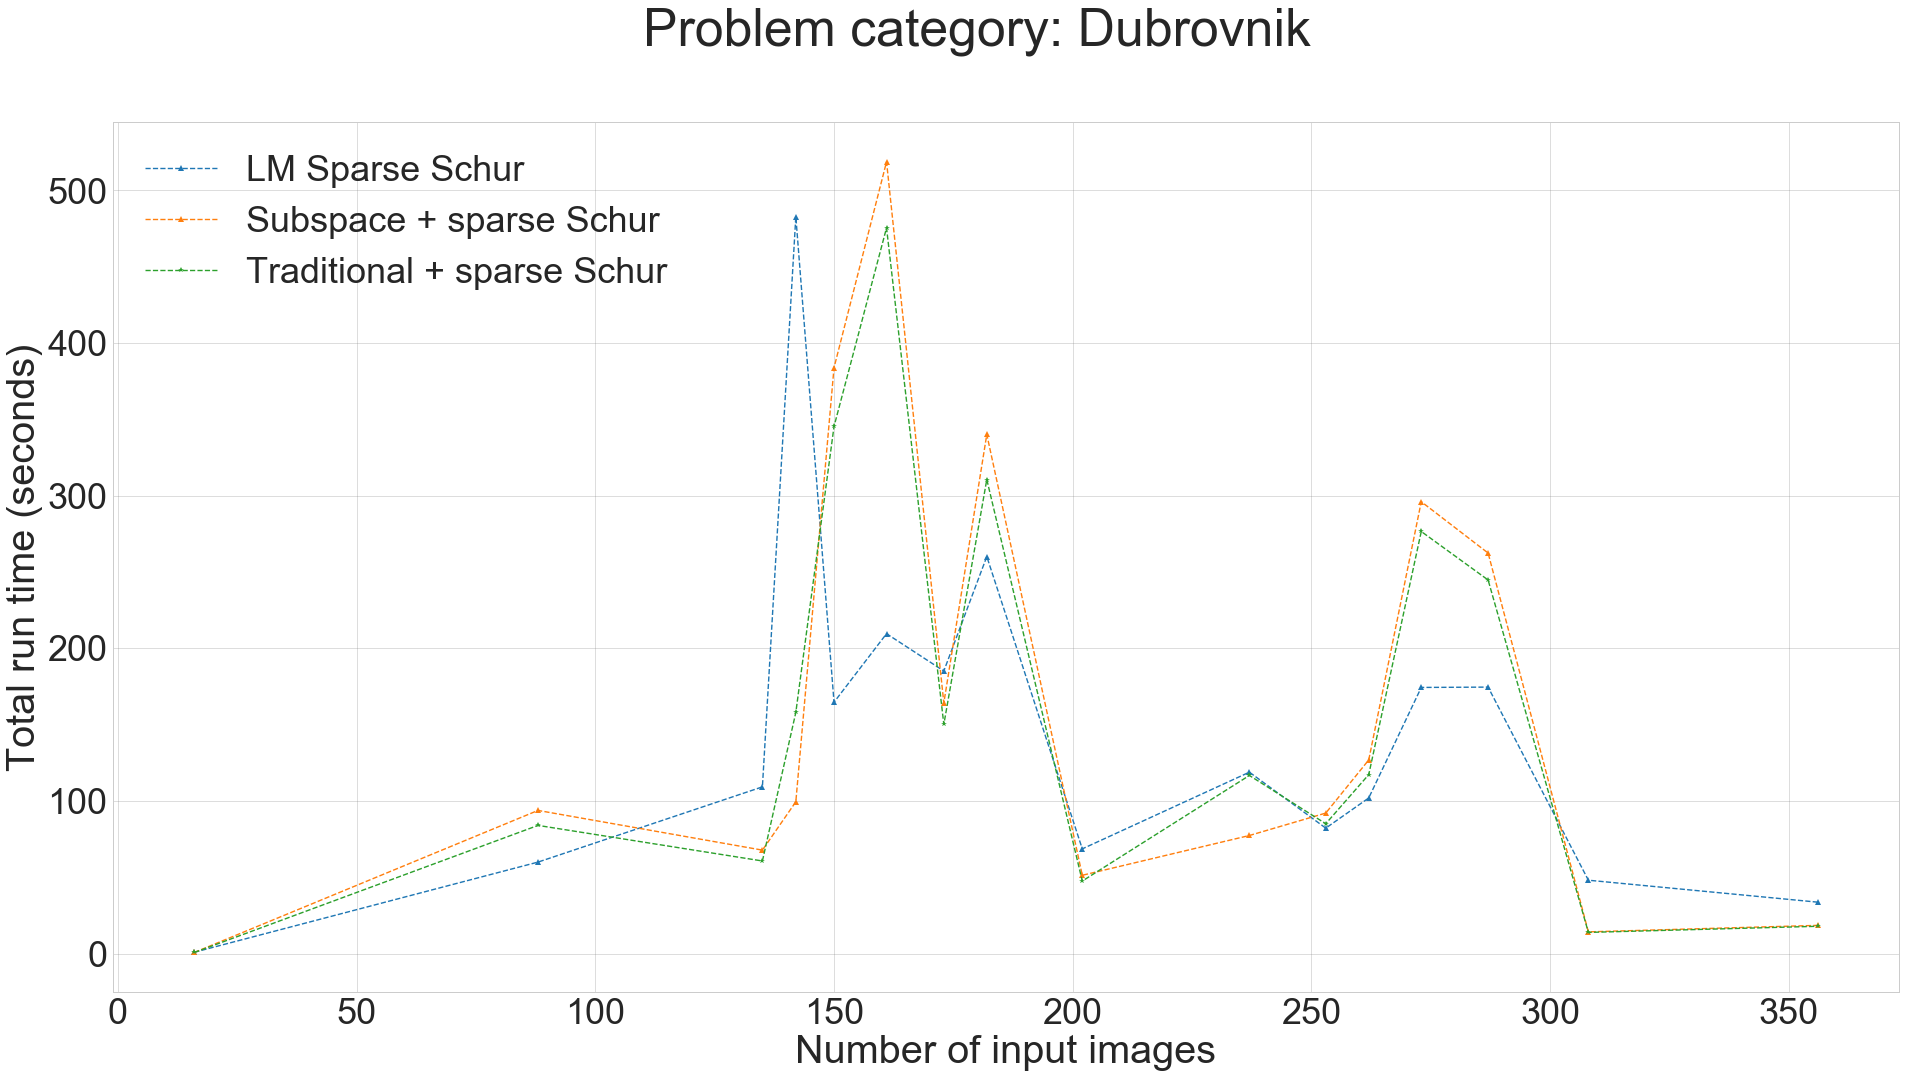

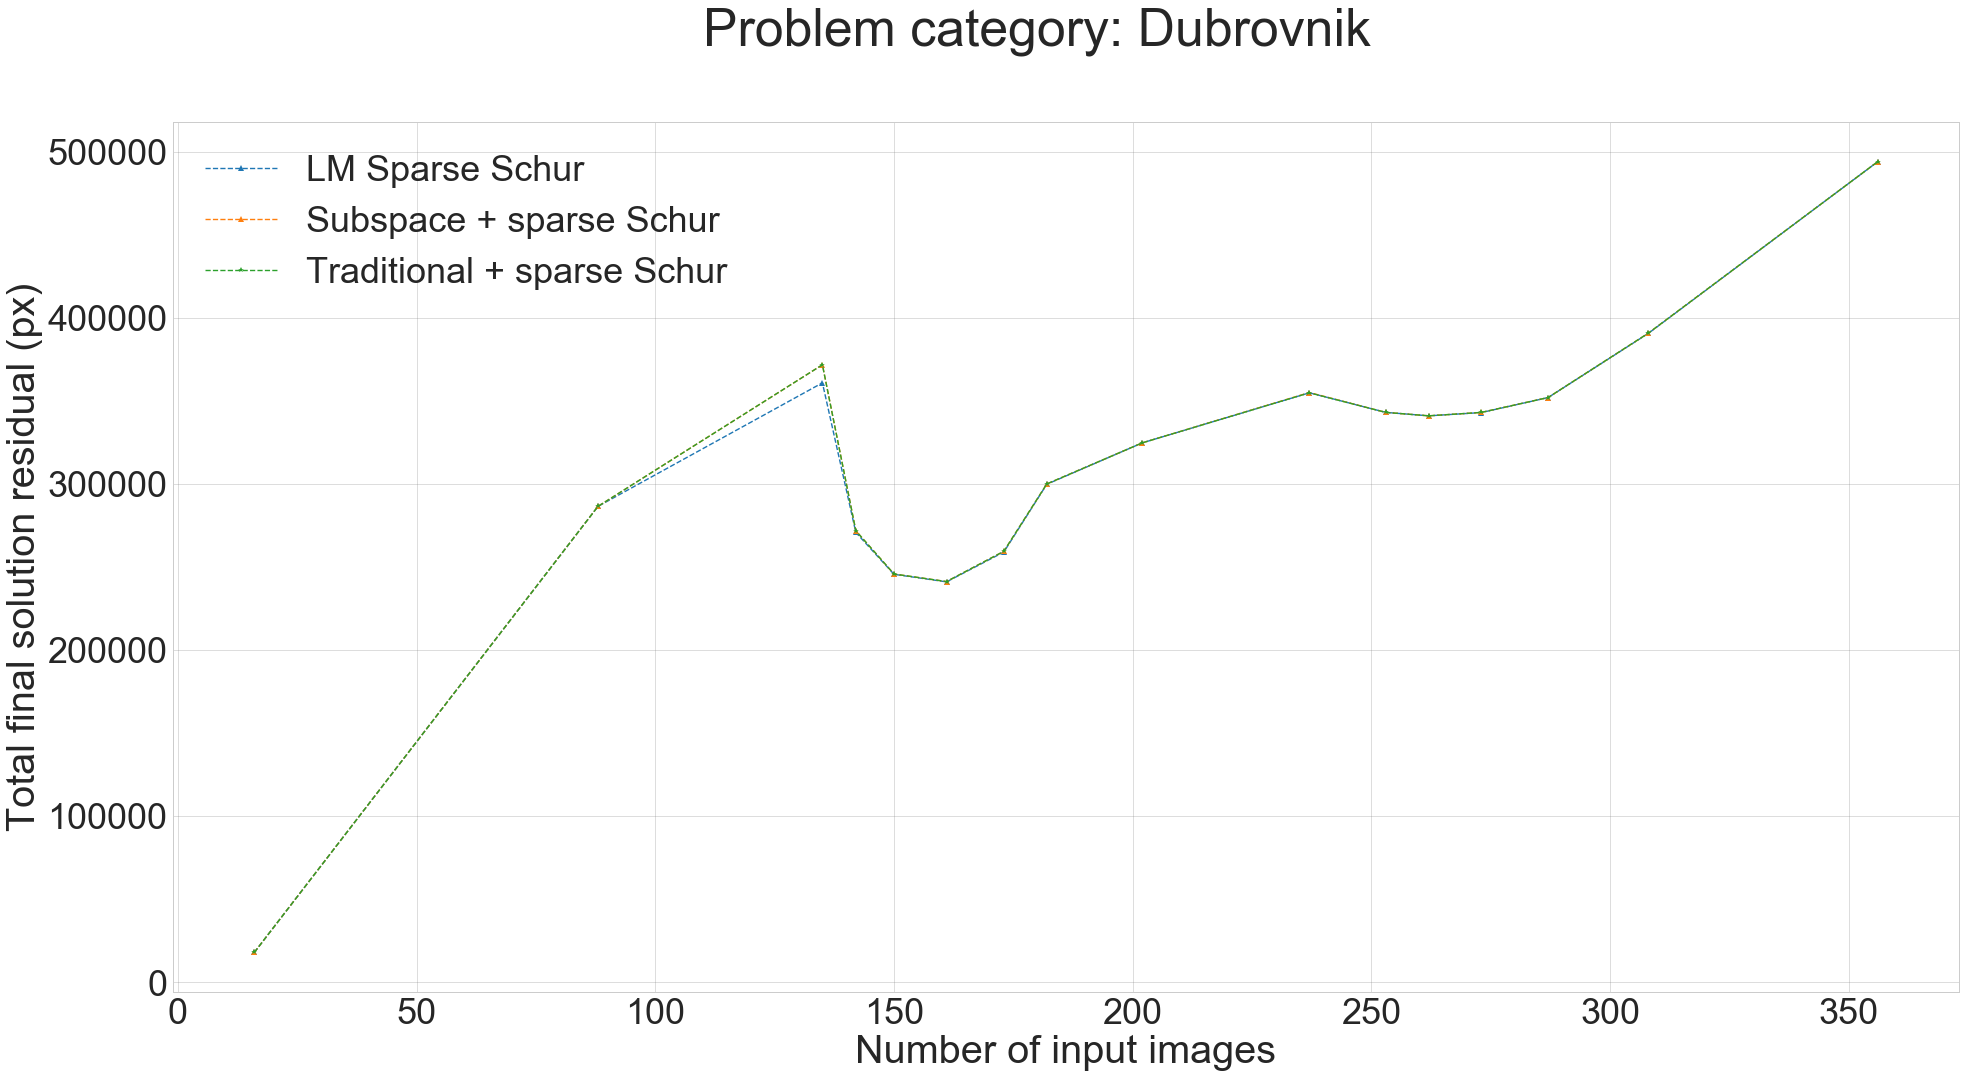

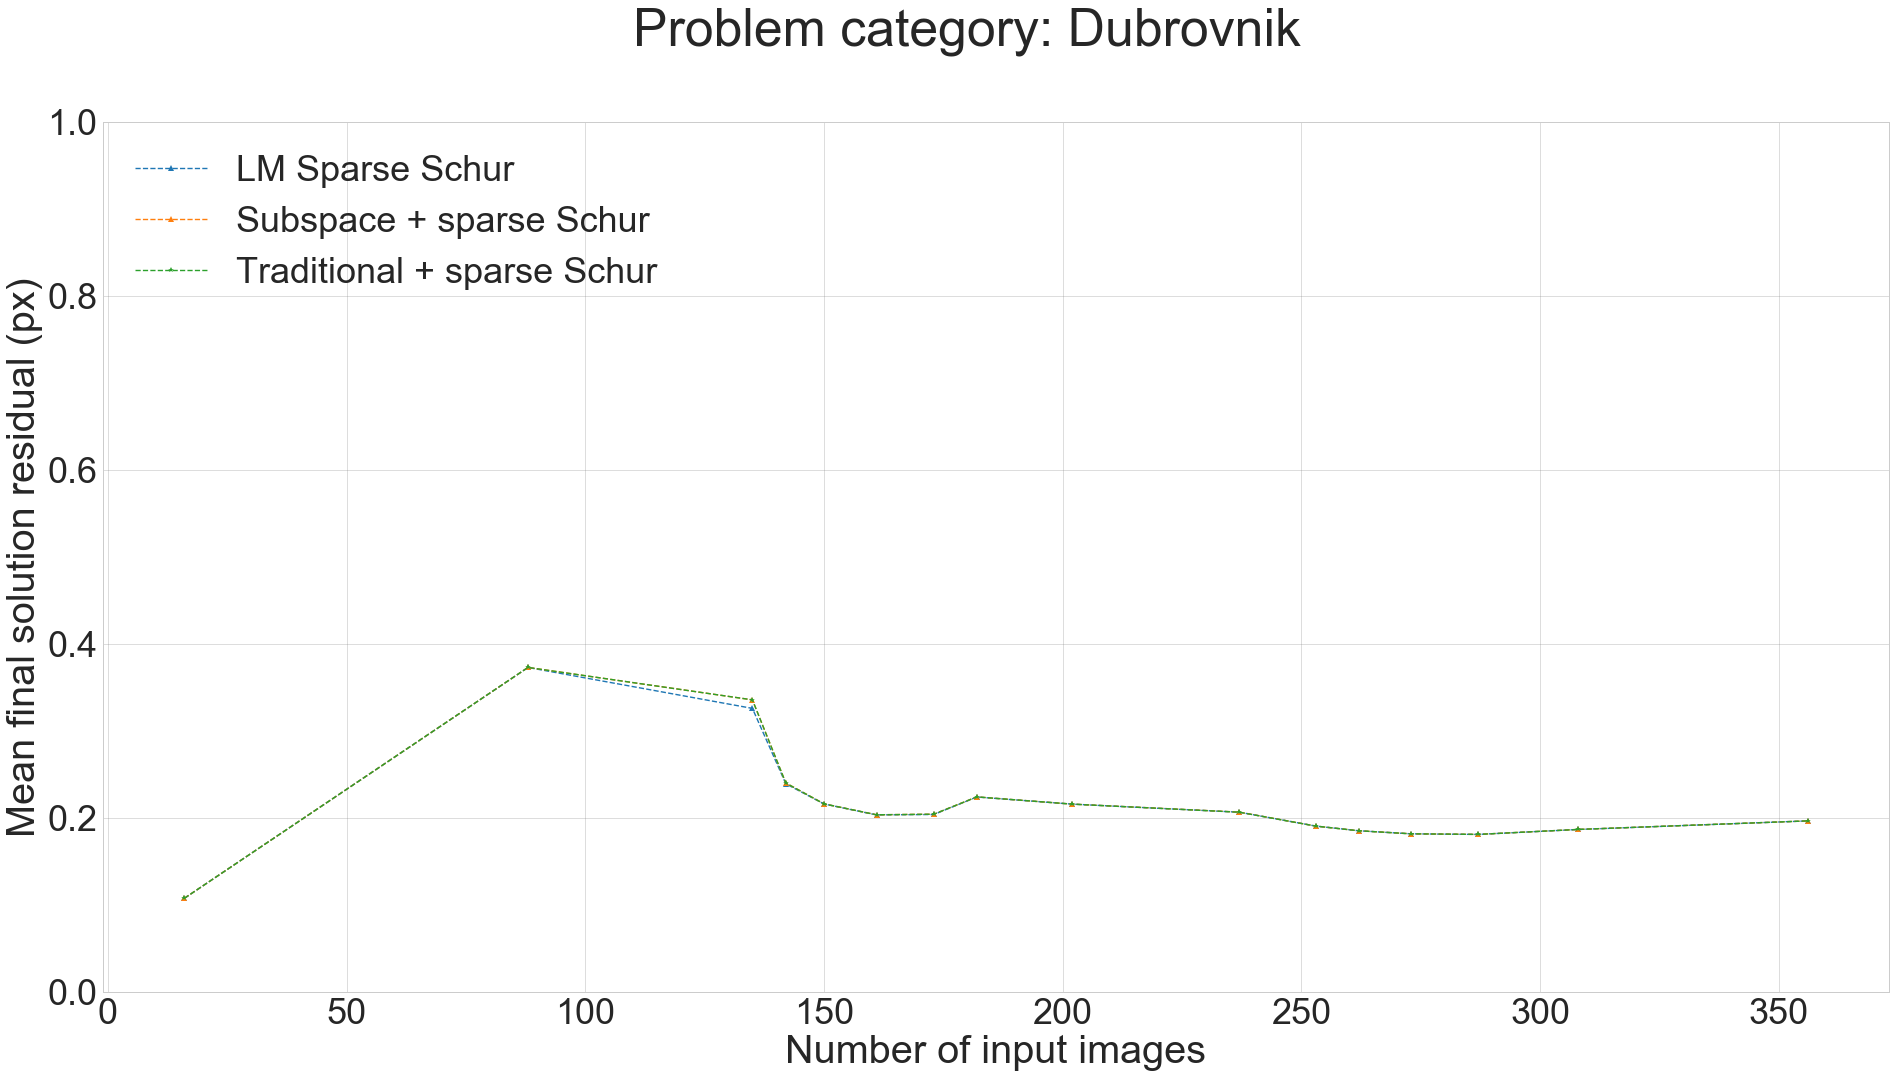

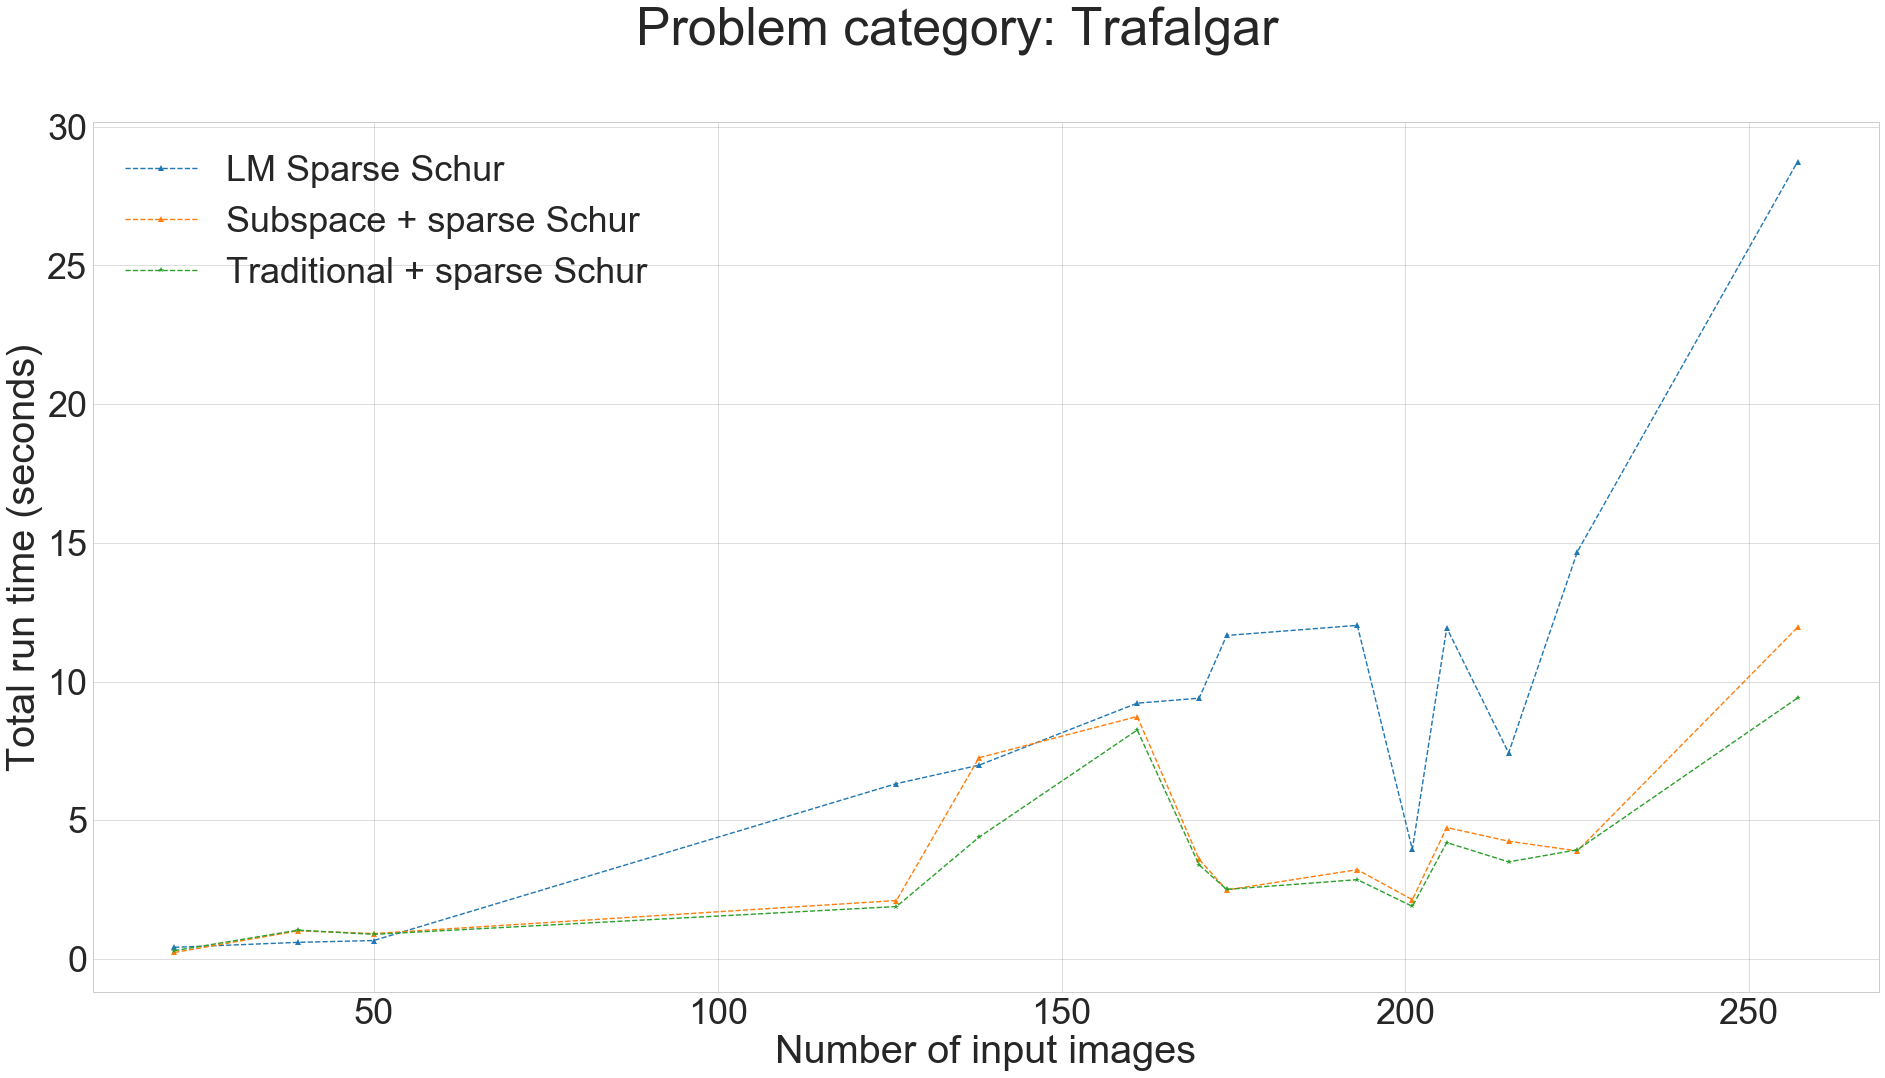

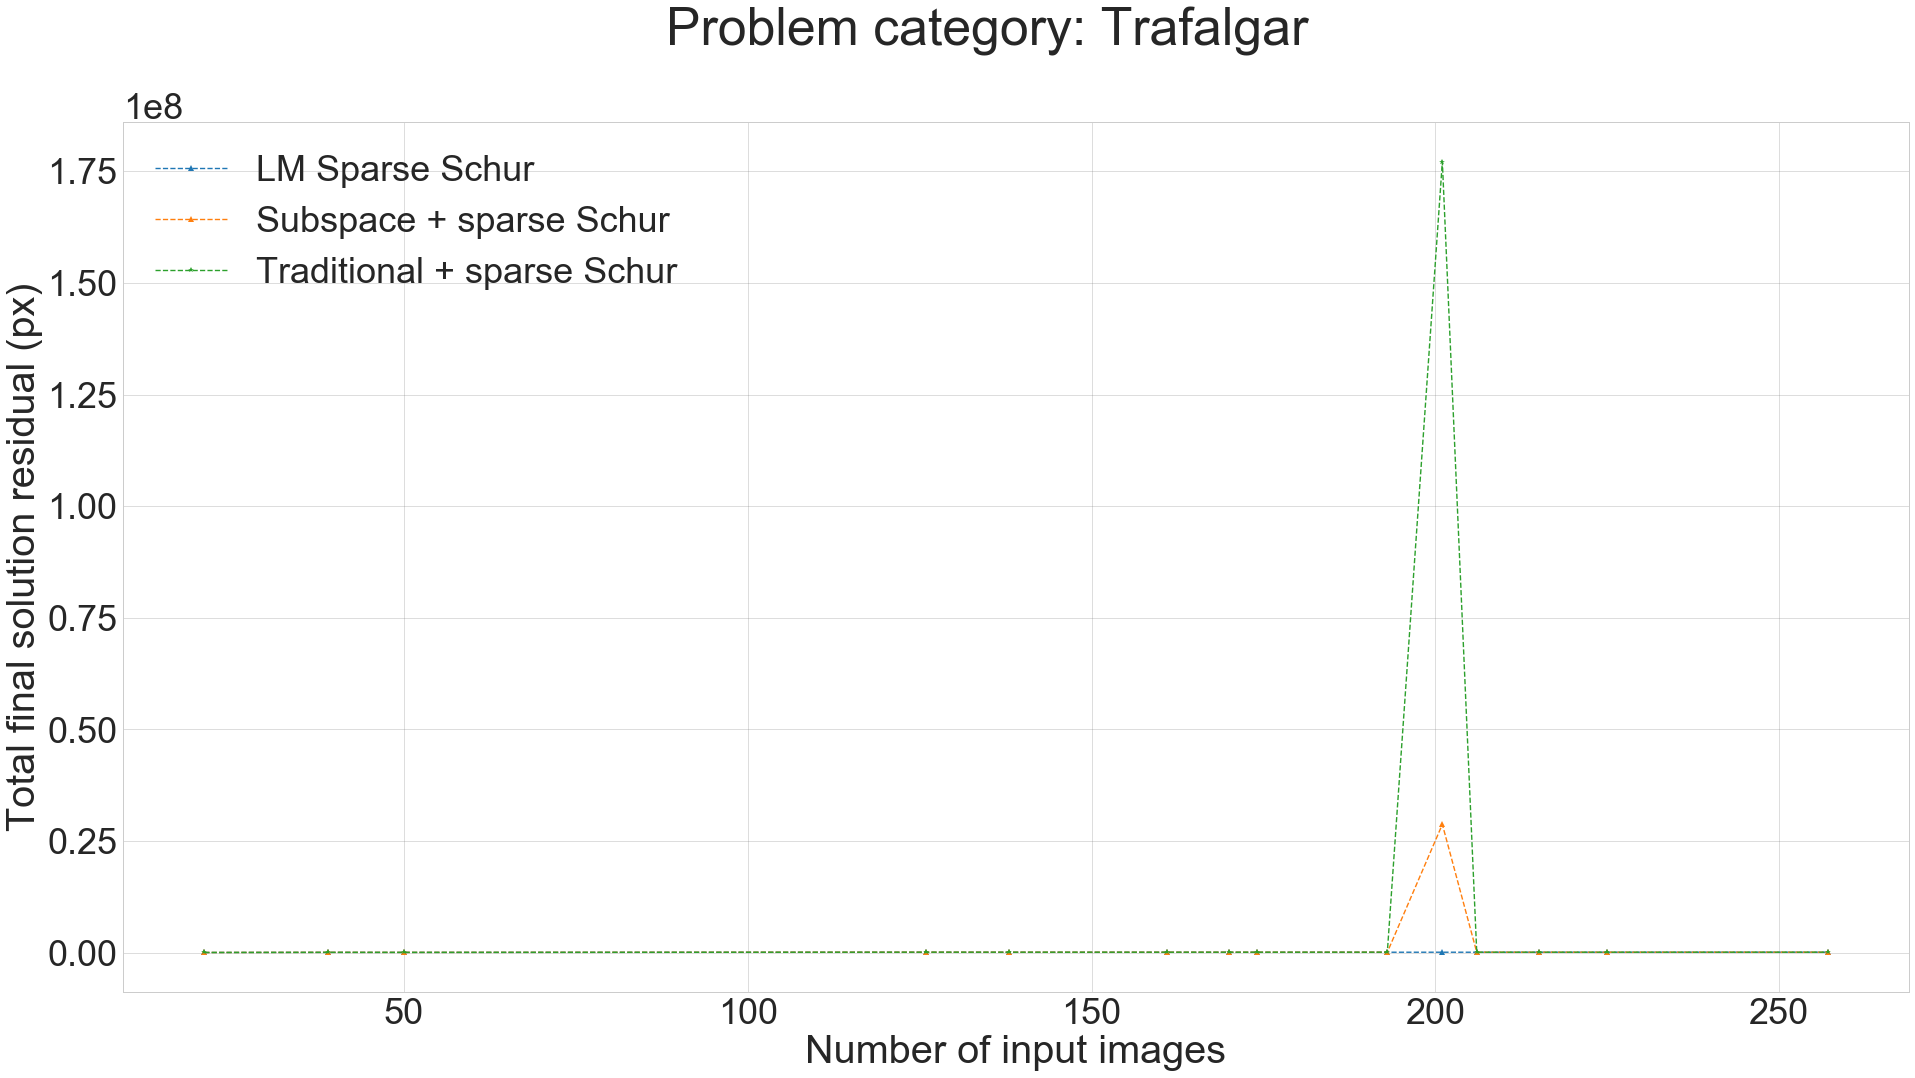

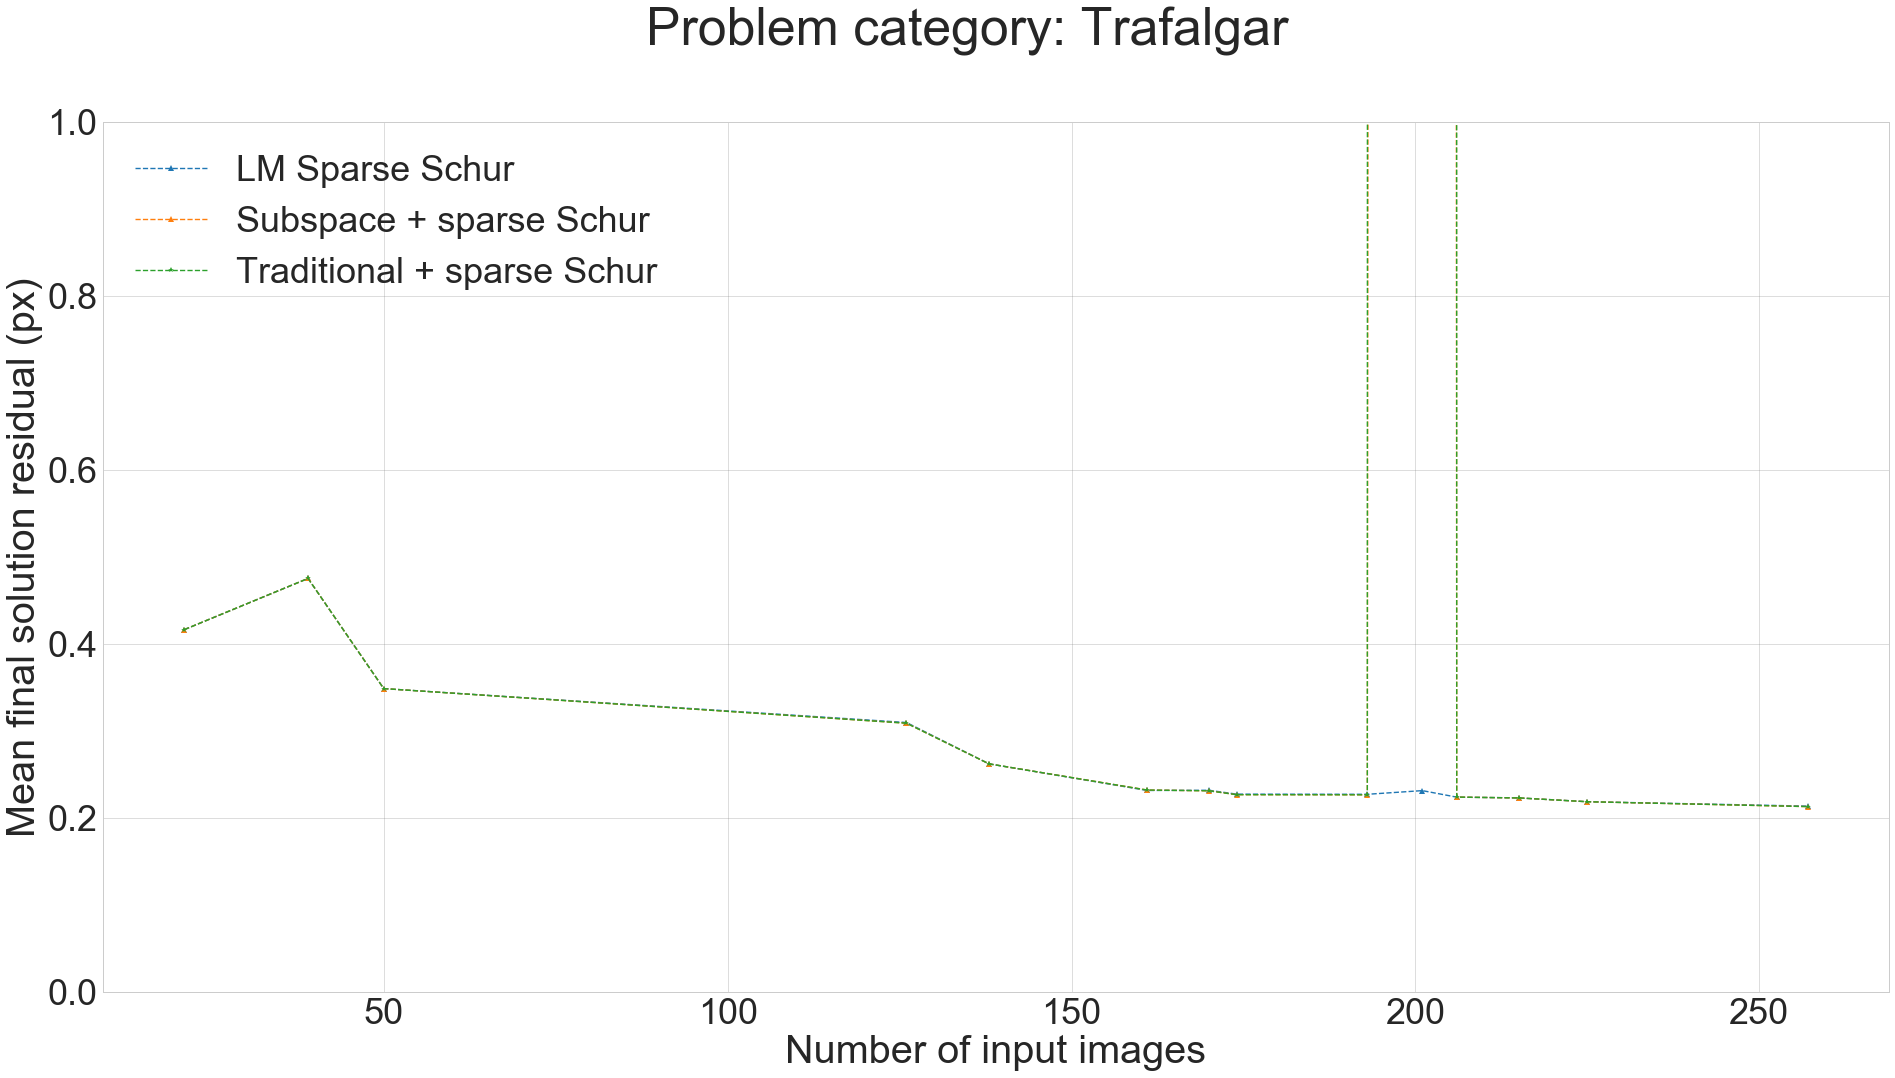

In [362]:
def hybrid_plot(data, seq, methods, joint_x_key, joint_y_keys, **kw):
    label = kw.get('label', 'joint')
    for joint_y_key in joint_y_keys:
        ax = None
        for meth in methods:
            ax = plot_category(data, seq, meth, 
                               x_axis=joint_x_key, y_axis=joint_y_key, 
                               methods=methods[meth], ax=ax)
            if joint_y_key == 'normalized_final_cost':
                ax.set_ylim(0.0, 1.0)
            elif joint_y_key == 'final_cost':
                pass
#                 if meth in ['CG-ls', 'lbfgs', 'SD']:
#                     ax.set_ylim(0, 5000000)
#                 else:
#                     ax.set_ylim(20000.0, 600000)
        plt.suptitle("Problem category: {}".format(seq.capitalize()))
        
        
        fig_fpath = os.path.join(PLOT_OUT, "{}-{}-{}".format(label, seq, joint_y_key))
        plt.savefig(fig_fpath + ".png")
        plt.savefig(fig_fpath + ".eps")
        plt.savefig(fig_fpath + ".pdf")
        
methods = {
#     'lm':['lm-ITERATIVE_SCHUR100', 'lm-SPARSE_SCHUR'],
    'lm':['lm-SPARSE_SCHUR'],
    'dogleg': ['dogleg-SUBSPACE_DOGLEG-SPARSE_SCHUR', 'dogleg-TRADITIONAL_DOGLEG-SPARSE_SCHUR']
}

joint_x_key = 'n_images'
# joint_x_key = 'n_points'
        
y_keys = ['time_seconds', 'final_cost', 'normalized_final_cost']
for joint_plot_seq in ['dubrovnik', 'trafalgar']:
    ax = hybrid_plot(data, joint_plot_seq, methods, joint_x_key, y_keys)

# print("TODO: is Iterative Schur already sparse? It's basically CG I think, so should support sparsity out of the box.")

## Steepest Descent

Without accounting for the specifics of the least-squares problem, gradient descent and BFGS methods
often fail to make meaningful progress on the problem.

Let's plot these things just in case, using a neat skull icon to indicate problems on which the methods
failed to make any progress!

In [352]:
data_line_search = {'trafalgar': load_files('../experiments', subdir='04', sequence_name='trafalgar', skip_short=False)}

In [355]:
# print(data_line_search['trafalgar']['CG-ls'])
# print(data_line_search['trafalgar']['LBFGS'])
# print(data_line_search['trafalgar']['SD'])

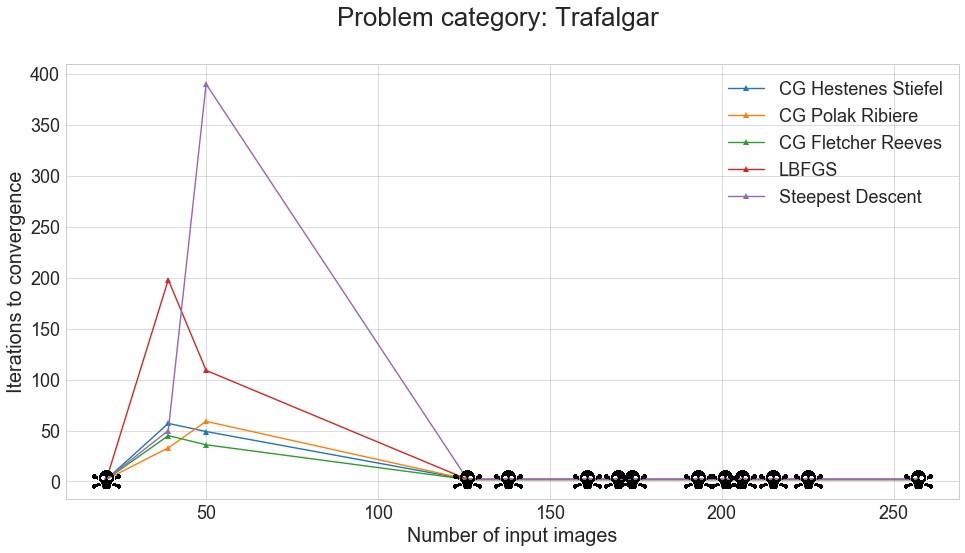

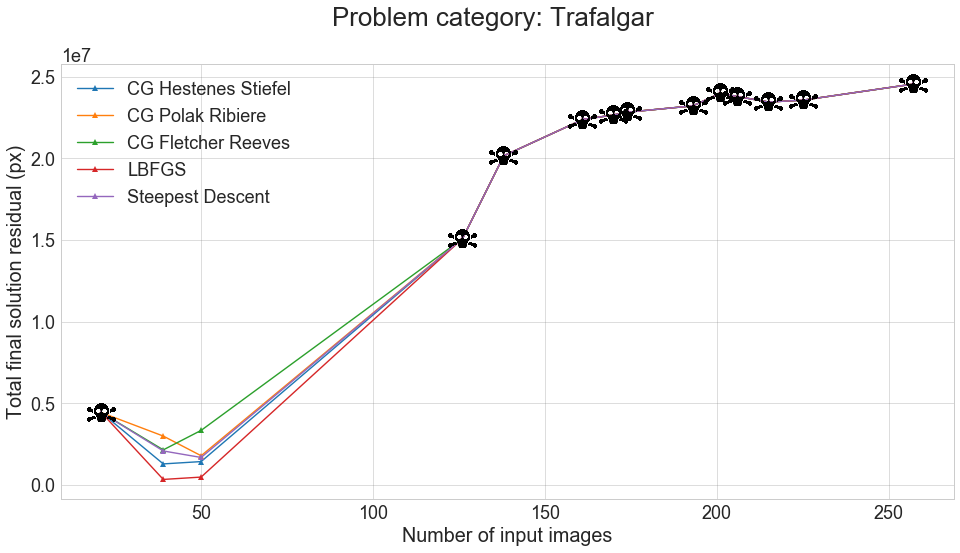

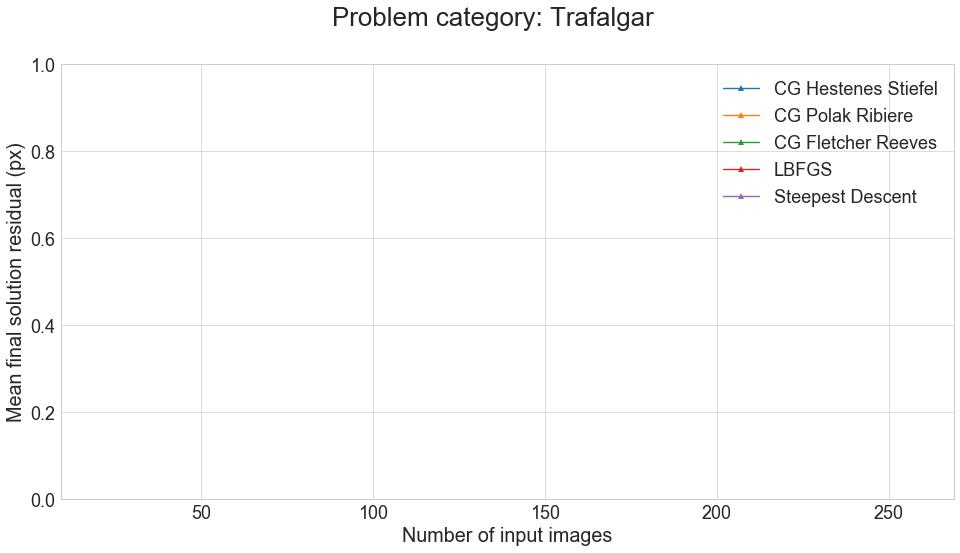

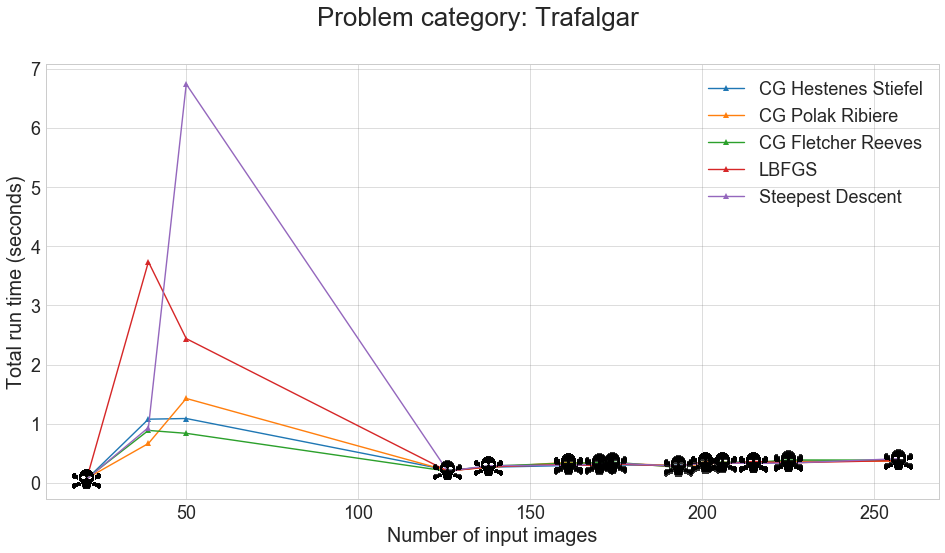

In [366]:
# TODO better method names
ls_methods = {
    'CG-ls': ['CG-ls HESTENES_STIEFEL', 'CG-ls POLAK_RIBIERE', 'CG-ls FLETCHER_REEVES'],
    'LBFGS': ['LBFGS'],
    'SD': ['SD']
}
hybrid_plot(data_line_search, 'trafalgar', ls_methods, 'n_images', 
            ['iterations', 'final_cost', 'normalized_final_cost', 'time_seconds'], label='simple-line-search')


## Cost Reduction over Time

I should also plot, for a fixed problem (say, the largest in Trafalgar), how fast the dogleg method approaches
the solution, compared to the LM one. It may be that the dogleg just converges earlier to a slightly worse
optimum, and the LM one just wastes a lot of time making minuscule improvements in the solution quality.

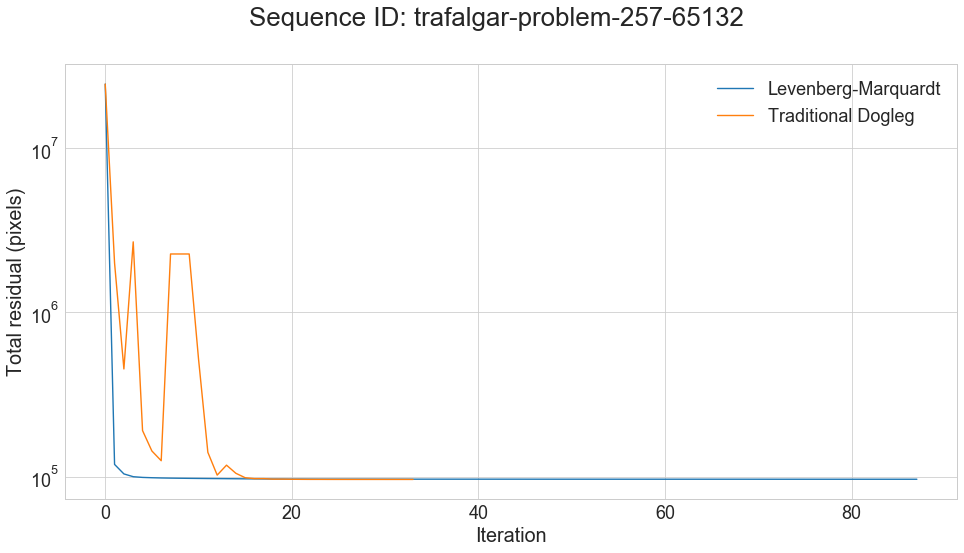

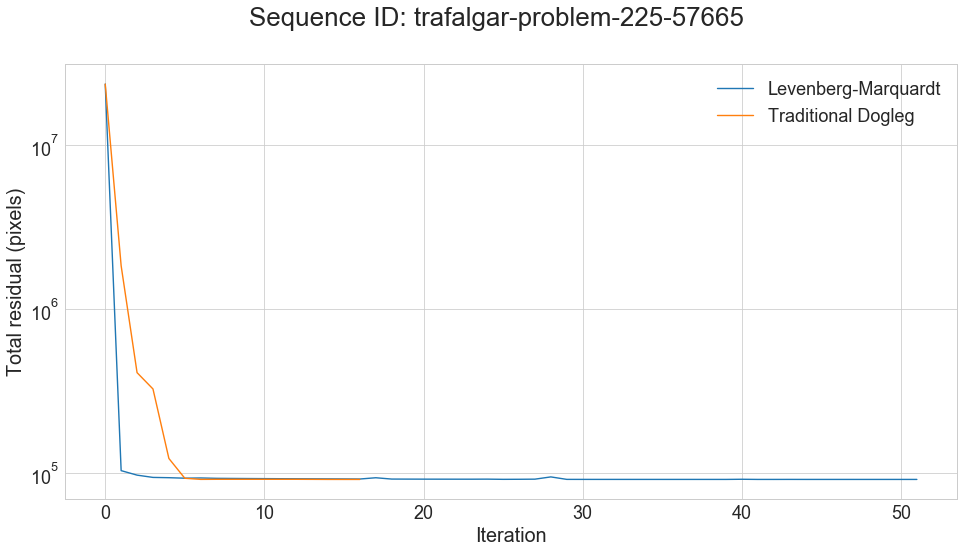

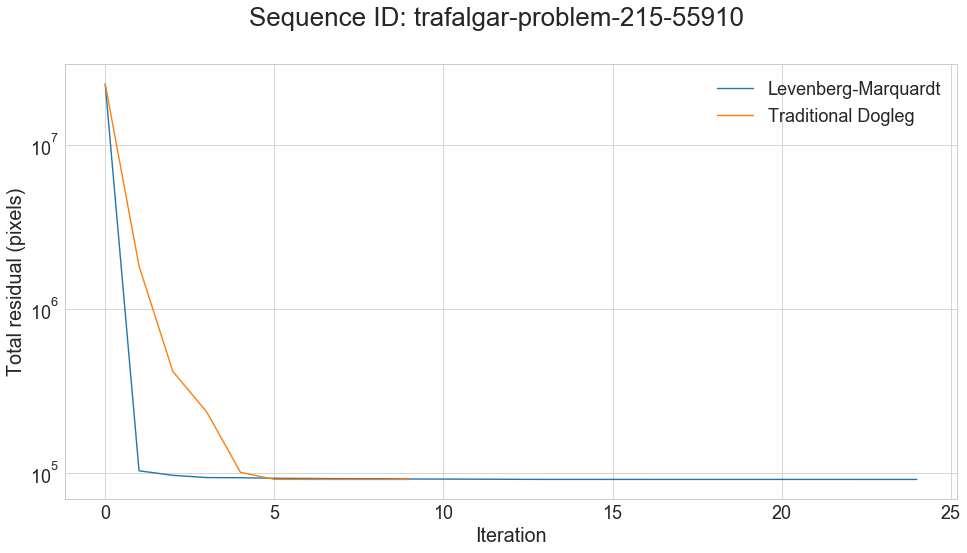

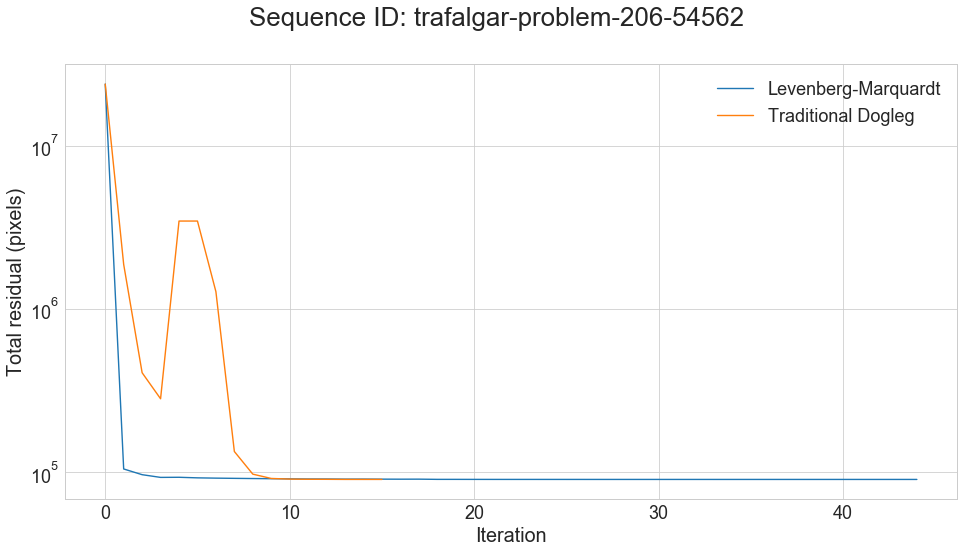

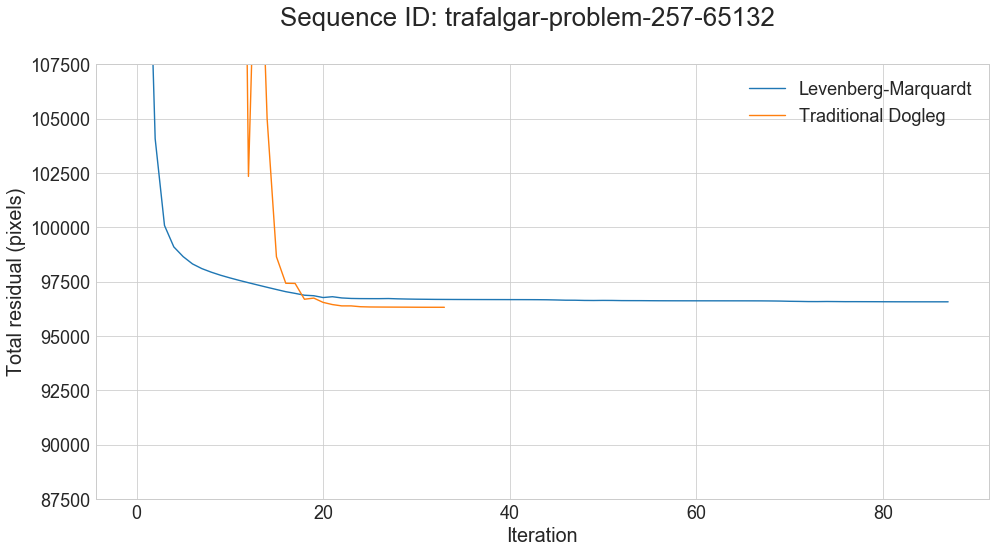

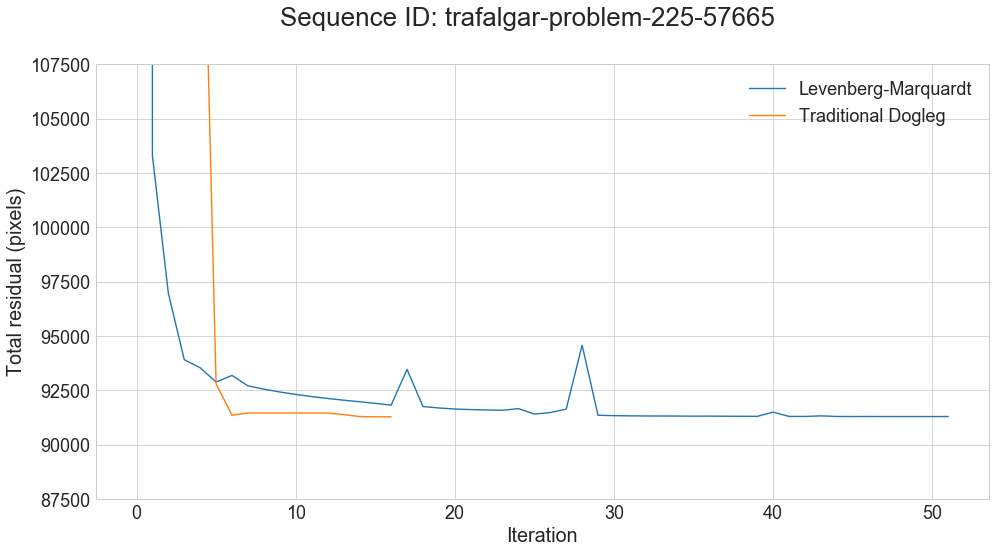

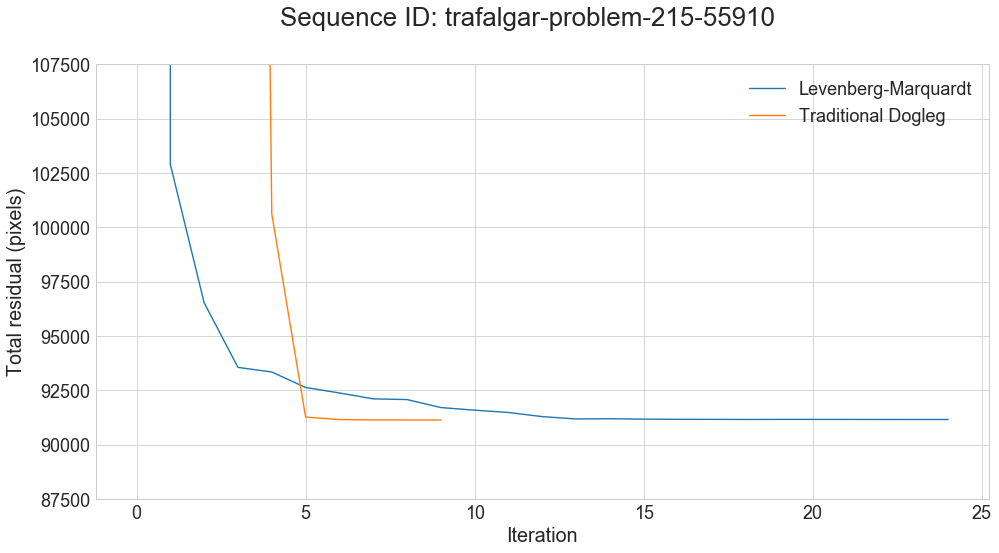

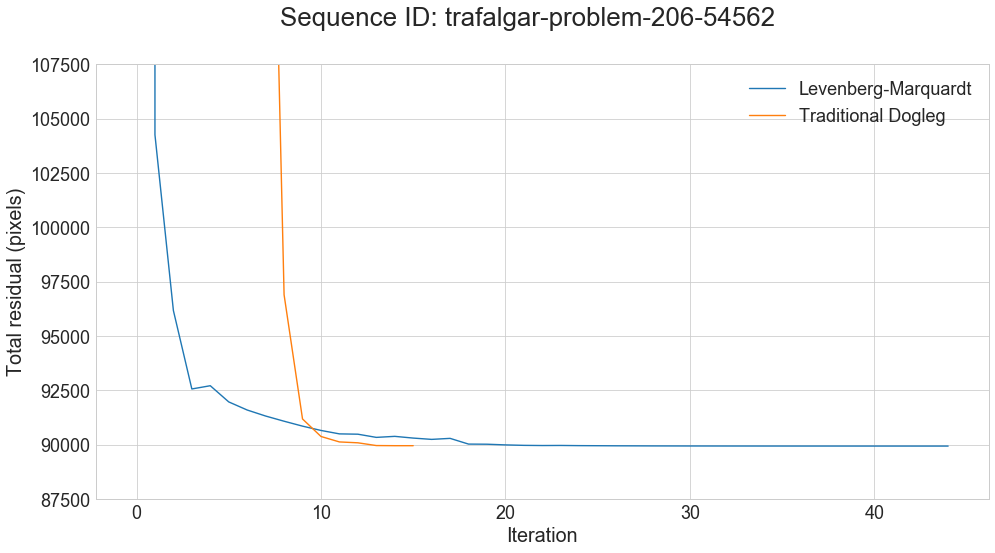

In [432]:
def read_iterates(fpath):
    return pd.read_csv(fpath)

lc_sequences = ['trafalgar-problem-257-65132', 'trafalgar-problem-225-57665', 
                'trafalgar-problem-215-55910', 'trafalgar-problem-206-54562']
methods = {
    'LEVENBERG_MARQUARDT': "Levenberg-Marquardt",
    'DOGLEG-TRADITIONAL_DOGLEG': "Traditional Dogleg",
    # Removed since it's almost identical to the traditional one
#     'DOGLEG-SUBSPACE_DOGLEG': "Subspace Dogleg"
}

def plot_cost_over_time(lc_sequences, methods, x_dim='iteration', y_dim='cost', **kw):
    """Plots the total residual as a function of the iteration."""
    offset = kw.get('offset', 0)
    # Whether to zoom into the y axis to see what happens near the convergence point.
    zoom = kw.get('zoom', False)
    out_dir = kw.get('out_dir', os.path.join('..', 'plots'))
    
    root = os.path.join(EXP_ROOT, '00')
    
    for seq in lc_sequences:
        fig = plt.figure(figsize=(16,8))
        fig.suptitle("Sequence ID: {}".format(seq))
        ax = fig.add_subplot(111)
        
        for method in methods:
            fname = 'results-{}-pre.txt-TRUST_REGION-{}-SPARSE_SCHUR-params.csv'.format(seq, method)
            fpath = os.path.join(root, fname)
            data = read_iterates(fpath)
            
            ax = data[offset:].plot(x_dim, y_dim, label=methods[method], ax=ax)
            
        # TODO(andreib): More generic.
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Total residual (pixels)")
        
        if zoom:
            ax.set_ylim([8.75*1e4, 1.075 * 1e5])
        else:
#             ax.set_ylim([9*1e4, 1.2 * 1e5])
            ax.semilogy()
        
        out_fname = 'single-run-{}-{}-{}-{}'.format(seq, x_dim, y_dim, 'zoom' if zoom else 'no-zoom')
        out_fpath = os.path.join(out_dir, out_fname)
        plt.savefig(out_fpath + ".png")
        plt.savefig(out_fpath + ".eps")


# print("Final LM cost:", lm_ss['cost'].iloc[-1])
# print("Final dogleg cost:", dl_ss['cost'].iloc[-1])
            
plot_cost_over_time(lc_sequences, methods, x_dim='iteration', zoom=False)
plot_cost_over_time(lc_sequences, methods, x_dim='iteration', zoom=True)
# plot_cost_over_time(lc_sequences, methods, x_dim='cumulative_time_in_seconds')

# dl_ss = read_iterates('../experiments/00/results-{}-pre.txt-TRUST_REGION-DOGLEG-TRADITIONAL_DOGLEG-SPARSE_SCHUR-params.csv'.format(sequence))
# print(len(lm_ss), len(dl_ss))

## Residual Histogram Over time

Should look at how this changes over time for the various methods. Because if an optimization procedure,
towards the end, when its steps are tiny, actually makes few but large changes (unlikely but should be 
investigated) to the params, then those steps would be justified. Otherwise, setting a coarser convergence
threshold would likely lead to basically identical results, but in a fraction of the time.

This experiment would require additional code in the experiment harness, as well as complicated plotting
code, and I won't have time to do that in the remaining time for this project.